In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms

root = "./dataset/mnist"
trn_dataset = datasets.MNIST(root,
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.Pad(2),
                                 transforms.ToTensor(), # image to Tensor
                                 transforms.Normalize(0,1)
                             ])) 

val_dataset = datasets.MNIST(root, 
                             download=True,
                             train=False,
                             transform= transforms.Compose([
                               transforms.Pad(2),
                               transforms.ToTensor(),
                               transforms.Normalize(0,1)
                           ]))

In [3]:
from torch.utils.data import DataLoader

batch_size = 256
trn_loader = DataLoader(trn_dataset,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size)

In [15]:
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch import save
from torch.utils.tensorboard import SummaryWriter
from NN.LeNet import LeNet

learning_rate = 1e-3
num_epoch = 20
net =LeNet().cuda()

criterion = CrossEntropyLoss()
optimizer =Adam(net.parameters(), lr=learning_rate)

summary = SummaryWriter(log_dir="runs/LeNet01")


trn_loss_list = []
val_loss_list = []
trn_size = len(trn_dataset)
val_size = len(val_dataset)
best_val_loss = float('inf')
for epoch in range(num_epoch):
    trn_loss = 0
    trn_acc =0
    net.train()
    for _, (x,label) in enumerate(trn_loader):
        x, label = x.cuda(), label.cuda()
        optimizer.zero_grad()
        pred = net(x)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        
        trn_loss += loss.item()
        pred,label = pred.cpu().detach().numpy(),label.cpu().detach().numpy()
        trn_acc += np.sum(np.argmax(pred,axis=1)==label)
        # del(memory saved)
        del loss,pred
        
    trn_loss/=len(trn_loader)
    trn_acc/=trn_size
    
    val_loss= 0
    val_acc=0
    net.eval()
    for _, (x,label) in enumerate(val_loader):
        x, label = x.cuda(), label.cuda()
        
        pred = net(x)
        loss = criterion(pred, label)
        
        val_loss += loss.item()
        pred,label = pred.cpu().detach().numpy(),label.cpu().detach().numpy()
        val_acc += np.sum(np.argmax(pred,axis=1)==label)
        del loss,pred
    val_loss/=len(val_loader)
    val_acc/=val_size
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | trn_acc: {:.3f} | val_acc: {:.3f}".format(
                epoch+1, num_epoch, trn_loss, val_loss, trn_acc, val_acc))
    if val_loss<best_val_loss:
        save(net.state_dict(),'./Model/LeNet.pth')
    summary.add_scalars('loss',{'valid':val_loss, 'train':trn_loss},epoch)    
    summary.add_scalars('acc',{'valid':val_acc, 'train':trn_acc},epoch)


epoch: 1/20 | trn loss: 0.6977 | val loss: 0.2654 | trn_acc: 0.790 | val_acc: 0.919
epoch: 2/20 | trn loss: 0.2030 | val loss: 0.1417 | trn_acc: 0.937 | val_acc: 0.955
epoch: 3/20 | trn loss: 0.1321 | val loss: 0.0937 | trn_acc: 0.960 | val_acc: 0.971
epoch: 4/20 | trn loss: 0.0981 | val loss: 0.0801 | trn_acc: 0.970 | val_acc: 0.976
epoch: 5/20 | trn loss: 0.0833 | val loss: 0.0762 | trn_acc: 0.974 | val_acc: 0.976
epoch: 6/20 | trn loss: 0.0713 | val loss: 0.0596 | trn_acc: 0.978 | val_acc: 0.981
epoch: 7/20 | trn loss: 0.0606 | val loss: 0.0630 | trn_acc: 0.981 | val_acc: 0.980
epoch: 8/20 | trn loss: 0.0548 | val loss: 0.0516 | trn_acc: 0.983 | val_acc: 0.984
epoch: 9/20 | trn loss: 0.0500 | val loss: 0.0593 | trn_acc: 0.985 | val_acc: 0.981
epoch: 10/20 | trn loss: 0.0449 | val loss: 0.0449 | trn_acc: 0.986 | val_acc: 0.985
epoch: 11/20 | trn loss: 0.0401 | val loss: 0.0415 | trn_acc: 0.987 | val_acc: 0.987
epoch: 12/20 | trn loss: 0.0399 | val loss: 0.0441 | trn_acc: 0.988 | val_

pred:7,true:7


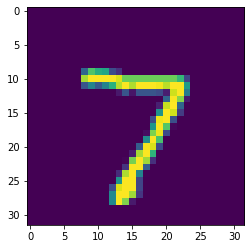

In [26]:
from torch import load
net = LeNet()
net.load_state_dict(load('Model/LeNet.pth'))
dataiter= iter(val_loader)
image, label = dataiter.next()
image, label  = image[0],label[0]
plt.imshow(image.reshape(32,32))
image = image.reshape(1,1,32,32)
net.eval()
print(f"pred:{label.item()},true:{np.argmax(net(image).cpu().detach().numpy())}")


In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir=/runs